# Taller 5 - Shazam para Pájaros en Colombia

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

try:
    from pydub import AudioSegment
    from pydub.utils import which
    AudioSegment.converter = which("ffmpeg")
    PYDUB_AVAILABLE = True
except ImportError:
    PYDUB_AVAILABLE = False
    print("pydub no está disponible. Instalarlo con: pip install pydub")

try:
    import librosa
    import librosa.display
    LIBROSA_AVAILABLE = True
except ImportError:
    LIBROSA_AVAILABLE = False
    print("librosa no está disponible. Instalarlo con: pip install librosa")

print(f"pydub disponible: {PYDUB_AVAILABLE}")
print(f"librosa disponible: {LIBROSA_AVAILABLE}")

pydub disponible: True
librosa disponible: True


## Funciones de Carga de Audio

In [2]:
def load_audio_librosa(file_path: str, sr: int = 22050, duration: float = None) -> Tuple[np.ndarray, int]:
    if not LIBROSA_AVAILABLE:
        raise RuntimeError("librosa no está disponible")
    
    audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
    return audio, sample_rate


def load_audio_pydub(file_path: str, target_sr: int = 22050, duration_sec: float = None) -> Tuple[np.ndarray, int]:
    if not PYDUB_AVAILABLE:
        raise RuntimeError("pydub no está disponible")
    
    audio = AudioSegment.from_file(file_path)
    
    if audio.channels > 1:
        audio = audio.set_channels(1)
    
    if audio.frame_rate != target_sr:
        audio = audio.set_frame_rate(target_sr)
    
    if duration_sec is not None:
        audio = audio[:int(duration_sec * 1000)]  
    
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    
    samples = samples / (2**15)  
    
    return samples, audio.frame_rate


def load_audio(file_path: str, sr: int = 22050, duration: float = None) -> Tuple[np.ndarray, int]:
    file_path = str(Path(file_path))
    
    if LIBROSA_AVAILABLE:
        return load_audio_librosa(file_path, sr=sr, duration=duration)
    elif PYDUB_AVAILABLE:
        return load_audio_pydub(file_path, target_sr=sr, duration_sec=duration)
    else:
        raise RuntimeError("No hay biblioteca de audio disponible. Instale librosa o pydub.")

## Análisis de Frecuencias con FFT

In [3]:
def compute_fft(audio: np.ndarray, sample_rate: int) -> Tuple[np.ndarray, np.ndarray]:
    fft_result = np.fft.fft(audio)
    
    n = len(audio)
    fft_positive = fft_result[:n//2]
    
    magnitudes = np.abs(fft_positive) / n
    
    frequencies = np.fft.fftfreq(n, 1/sample_rate)[:n//2]
    
    return frequencies, magnitudes


def get_dominant_frequencies(frequencies: np.ndarray, magnitudes: np.ndarray, 
                            top_n: int = 10, min_freq: float = 100, 
                            max_freq: float = 8000) -> List[Tuple[float, float]]:
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    freq_filtered = frequencies[mask]
    mag_filtered = magnitudes[mask]
    
    top_indices = np.argsort(mag_filtered)[-top_n:][::-1]
    
    dominant_freqs = [(freq_filtered[i], mag_filtered[i]) for i in top_indices]
    
    return dominant_freqs


def compute_spectrogram(audio: np.ndarray, sample_rate: int, 
                       n_fft: int = 2048, hop_length: int = 512) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if LIBROSA_AVAILABLE:
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft)
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    else:
        n_frames = 1 + (len(audio) - n_fft) // hop_length
        spectrogram = np.zeros((n_fft // 2 + 1, n_frames))
        
        for i in range(n_frames):
            start = i * hop_length
            frame = audio[start:start + n_fft]
            if len(frame) < n_fft:
                frame = np.pad(frame, (0, n_fft - len(frame)))
            
            fft_frame = np.fft.fft(frame)
            spectrogram[:, i] = np.abs(fft_frame[:n_fft//2 + 1])
        
        spectrogram_db = 20 * np.log10(spectrogram + 1e-10)
    
    times = np.arange(spectrogram_db.shape[1]) * hop_length / sample_rate
    frequencies = np.linspace(0, sample_rate / 2, spectrogram_db.shape[0])
    
    return times, frequencies, spectrogram_db

## Funciones de Visualización

In [4]:
def plot_waveform(audio: np.ndarray, sample_rate: int, title: str = "Forma de Onda"):
    duration = len(audio) / sample_rate
    time = np.linspace(0, duration, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time, audio, linewidth=0.5, alpha=0.7)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_fft_spectrum(frequencies: np.ndarray, magnitudes: np.ndarray, 
                     title: str = "Espectro de Frecuencias (FFT)",
                     max_freq: float = 8000):
    mask = frequencies <= max_freq
    
    plt.figure(figsize=(14, 5))
    plt.plot(frequencies[mask], magnitudes[mask], linewidth=1)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_spectrogram(times: np.ndarray, frequencies: np.ndarray, 
                    spectrogram: np.ndarray, title: str = "Espectrograma",
                    max_freq: float = 8000):
    mask = frequencies <= max_freq
    
    plt.figure(figsize=(14, 6))
    plt.imshow(spectrogram[mask, :], aspect='auto', origin='lower', 
               extent=[times[0], times[-1], frequencies[mask][0], frequencies[mask][-1]],
               cmap='viridis')
    plt.colorbar(label='Magnitud (dB)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_comparison(audio_dict: Dict[str, Tuple[np.ndarray, int]], max_freq: float = 8000):
    n_audios = len(audio_dict)
    fig, axes = plt.subplots(n_audios, 1, figsize=(14, 4*n_audios))
    
    if n_audios == 1:
        axes = [axes]
    
    for ax, (name, (audio, sr)) in zip(axes, audio_dict.items()):
        freqs, mags = compute_fft(audio, sr)
        mask = freqs <= max_freq
        
        ax.plot(freqs[mask], mags[mask], linewidth=1)
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Magnitud')
        ax.set_title(f'Espectro: {name}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Sistema de Identificación de Aves

In [5]:
def create_audio_fingerprint(audio: np.ndarray, sample_rate: int, 
                            n_top_freqs: int = 20) -> np.ndarray:
    freqs, mags = compute_fft(audio, sample_rate)
    dominant = get_dominant_frequencies(freqs, mags, top_n=n_top_freqs)
    
    fingerprint = np.array([f for f, m in dominant])
    return np.sort(fingerprint)


def compare_fingerprints(fp1: np.ndarray, fp2: np.ndarray, tolerance: float = 50) -> float:
    matches = 0
    for f1 in fp1:
        if np.any(np.abs(fp2 - f1) < tolerance):
            matches += 1
    
    similarity = matches / min(len(fp1), len(fp2))
    return similarity


class BirdIdentifier:
    
    def __init__(self, sample_rate: int = 22050):
        self.sample_rate = sample_rate
        self.database: Dict[str, np.ndarray] = {}
    
    def add_reference(self, species_name: str, audio_path: str, duration: float = None):
        audio, sr = load_audio(audio_path, sr=self.sample_rate, duration=duration)
        fingerprint = create_audio_fingerprint(audio, sr)
        self.database[species_name] = fingerprint
        print(f"Agregado: {species_name}")
        print(f"  Frecuencias dominantes: {fingerprint[:5].astype(int)} ... Hz")
    
    def identify(self, audio_path: str, duration: float = None, top_n: int = 3) -> List[Tuple[str, float]]:
        if not self.database:
            raise RuntimeError("La base de datos está vacía. Agregue referencias primero.")
        
        audio, sr = load_audio(audio_path, sr=self.sample_rate, duration=duration)
        fingerprint = create_audio_fingerprint(audio, sr)
        
        results = []
        for species, ref_fp in self.database.items():
            similarity = compare_fingerprints(fingerprint, ref_fp)
            results.append((species, similarity))

        results.sort(key=lambda x: x[1], reverse=True)
        
        return results[:top_n]
    
    def print_database(self):
        print(f"\n{'='*70}")
        print(f"BASE DE DATOS DE AVES")
        print(f"{'='*70}")
        for species, fp in self.database.items():
            print(f"\n{species}:")
            print(f"  Frecuencias dominantes (Hz): {fp[:10].astype(int)}")

## Cargar Audios de Referencia

In [6]:
DATA_DIR = Path("../data")

audio_files = {
    "Red Howler (Alouatta seniculus)": DATA_DIR / "XC979159 - Colombian Red Howler - Alouatta seniculus.mp3",
    "Guacharaca (MP3)": DATA_DIR / "guacharaca.mp3",
    "Guacharaca (MP4)": DATA_DIR / "guacharaca.MP4"
}

available_files = {}
for name, path in audio_files.items():
    if path.exists():
        available_files[name] = path
        print(f"✓ {name}: {path.name}")
    else:
        print(f"✗ {name}: No encontrado")

print(f"\nArchivos disponibles: {len(available_files)}")

✓ Red Howler (Alouatta seniculus): XC979159 - Colombian Red Howler - Alouatta seniculus.mp3
✓ Guacharaca (MP3): guacharaca.mp3
✓ Guacharaca (MP4): guacharaca.MP4

Archivos disponibles: 3


## Análisis del Red Howler (Alouatta seniculus)

In [7]:
howler_path = DATA_DIR / "XC979159 - Colombian Red Howler - Alouatta seniculus.mp3"

if howler_path.exists():
    print("Cargando Red Howler...")
    howler_audio, howler_sr = load_audio(str(howler_path), sr=22050, duration=10)
    print(f"  Sample rate: {howler_sr} Hz")
    print(f"  Duración: {len(howler_audio)/howler_sr:.2f} s")
    print(f"  Muestras: {len(howler_audio):,}")
else:
    print("Archivo no encontrado")

Cargando Red Howler...
  Sample rate: 22050 Hz
  Duración: 10.00 s
  Muestras: 220,500


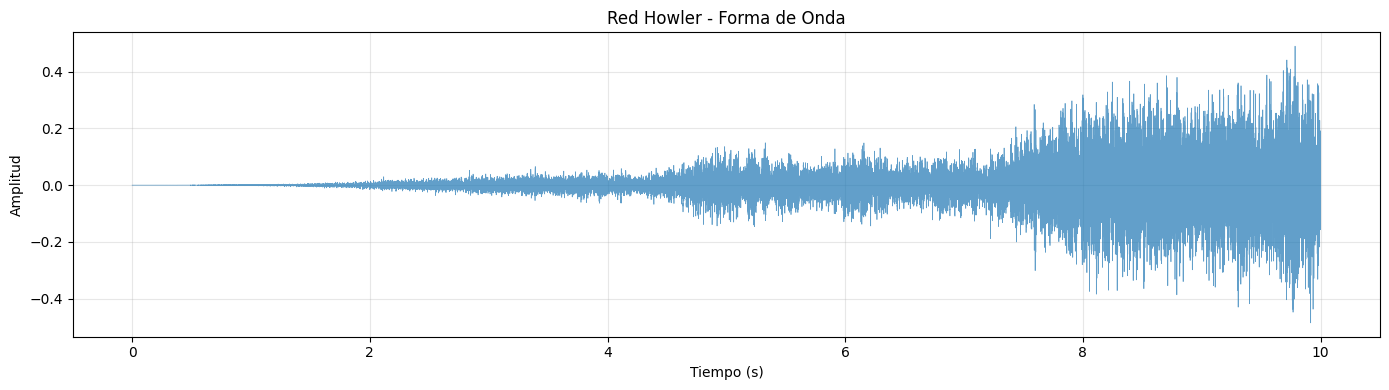

In [8]:
if howler_path.exists():
    plot_waveform(howler_audio, howler_sr, "Red Howler - Forma de Onda")

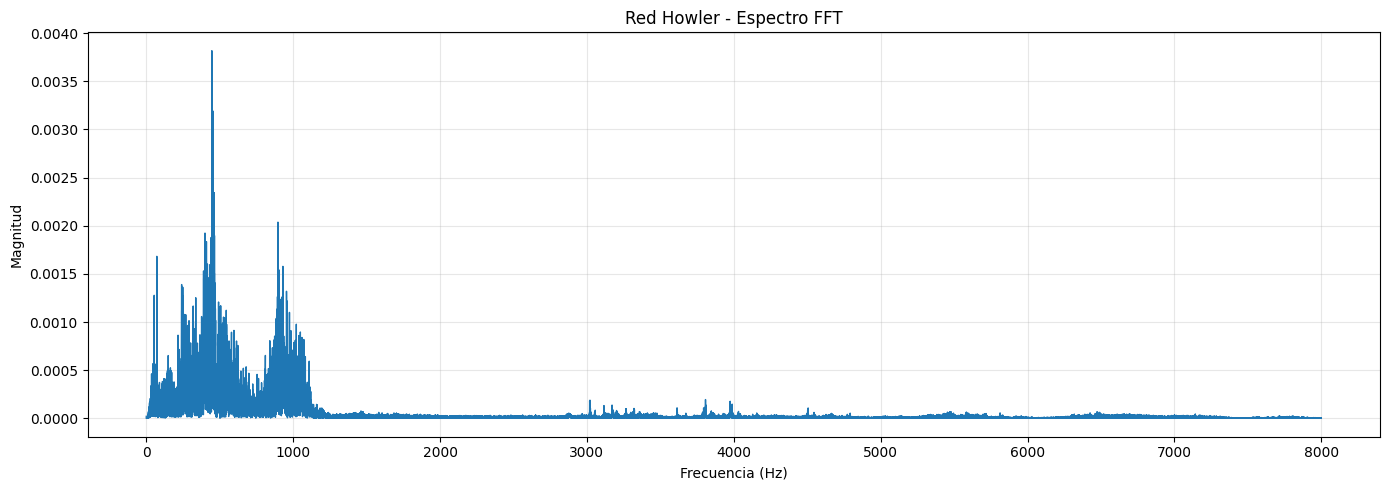

In [9]:
if howler_path.exists():
    howler_freqs, howler_mags = compute_fft(howler_audio, howler_sr)
    plot_fft_spectrum(howler_freqs, howler_mags, "Red Howler - Espectro FFT", max_freq=8000)

In [10]:
if howler_path.exists():
    dominant_freqs = get_dominant_frequencies(howler_freqs, howler_mags, top_n=15)
    print("Frecuencias dominantes del Red Howler:")
    print("="*50)
    for i, (freq, mag) in enumerate(dominant_freqs, 1):
        print(f"{i:2d}. {freq:7.1f} Hz  (magnitud: {mag:.6f})")

Frecuencias dominantes del Red Howler:
 1.   446.5 Hz  (magnitud: 0.003817)
 2.   446.6 Hz  (magnitud: 0.003566)
 3.   445.9 Hz  (magnitud: 0.003545)
 4.   446.4 Hz  (magnitud: 0.003334)
 5.   445.8 Hz  (magnitud: 0.003332)
 6.   446.7 Hz  (magnitud: 0.003221)
 7.   454.2 Hz  (magnitud: 0.003191)
 8.   454.9 Hz  (magnitud: 0.003106)
 9.   446.8 Hz  (magnitud: 0.003099)
10.   445.7 Hz  (magnitud: 0.003093)
11.   454.3 Hz  (magnitud: 0.003074)
12.   454.8 Hz  (magnitud: 0.002951)
13.   454.1 Hz  (magnitud: 0.002909)
14.   453.1 Hz  (magnitud: 0.002845)
15.   453.2 Hz  (magnitud: 0.002781)


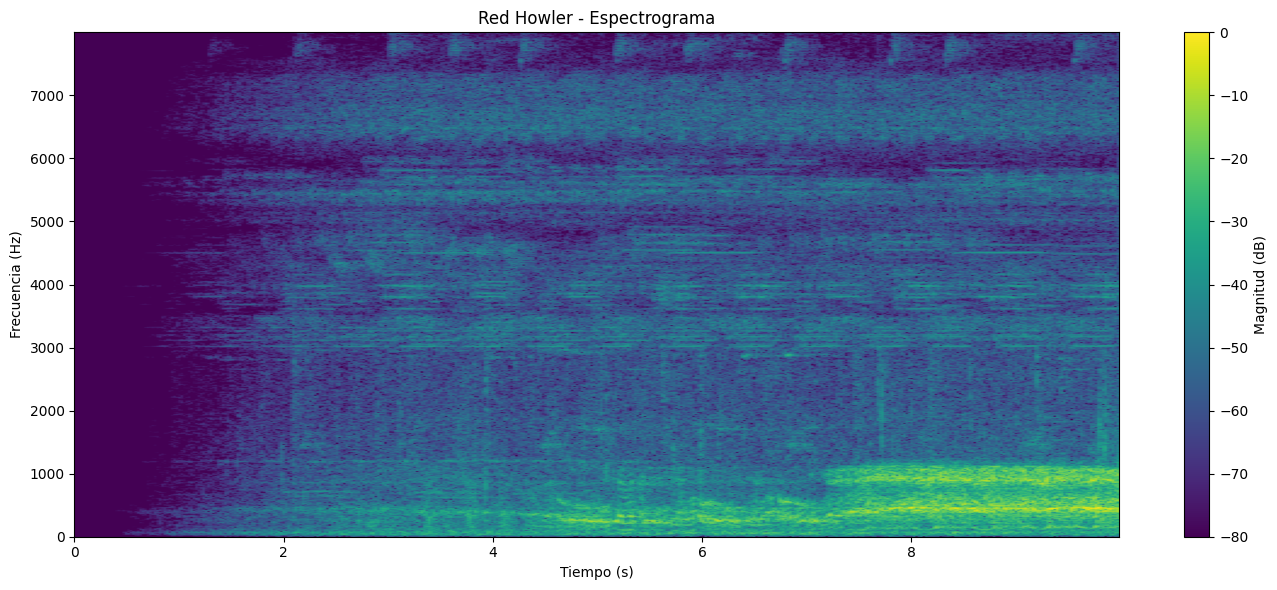

In [11]:
if howler_path.exists():
    times, freqs_spec, spec = compute_spectrogram(howler_audio, howler_sr)
    plot_spectrogram(times, freqs_spec, spec, "Red Howler - Espectrograma", max_freq=8000)

## Análisis de la Guacharaca

In [12]:
guacharaca_path = DATA_DIR / "guacharaca.mp3"

if guacharaca_path.exists():
    print("Cargando Guacharaca...")
    guacharaca_audio, guacharaca_sr = load_audio(str(guacharaca_path), sr=22050, duration=10)
    print(f"  Sample rate: {guacharaca_sr} Hz")
    print(f"  Duración: {len(guacharaca_audio)/guacharaca_sr:.2f} s")
    print(f"  Muestras: {len(guacharaca_audio):,}")
else:
    print("Archivo MP3 no encontrado, intentando MP4...")
    guacharaca_path = DATA_DIR / "guacharaca.MP4"
    if guacharaca_path.exists():
        guacharaca_audio, guacharaca_sr = load_audio(str(guacharaca_path), sr=22050, duration=10)
        print(f"  Sample rate: {guacharaca_sr} Hz")
        print(f"  Duración: {len(guacharaca_audio)/guacharaca_sr:.2f} s")

Cargando Guacharaca...
  Sample rate: 22050 Hz
  Duración: 5.64 s
  Muestras: 124,416


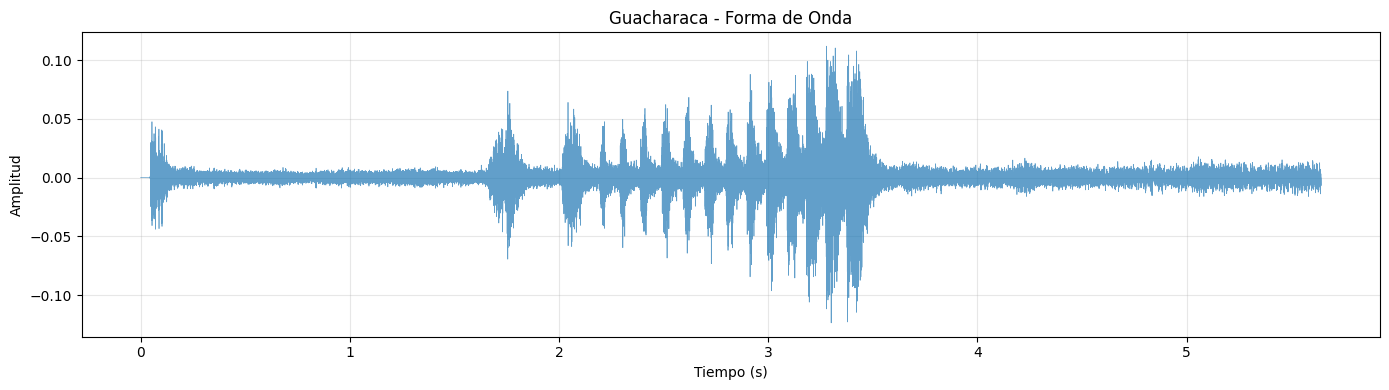

In [13]:
if guacharaca_path.exists():
    plot_waveform(guacharaca_audio, guacharaca_sr, "Guacharaca - Forma de Onda")

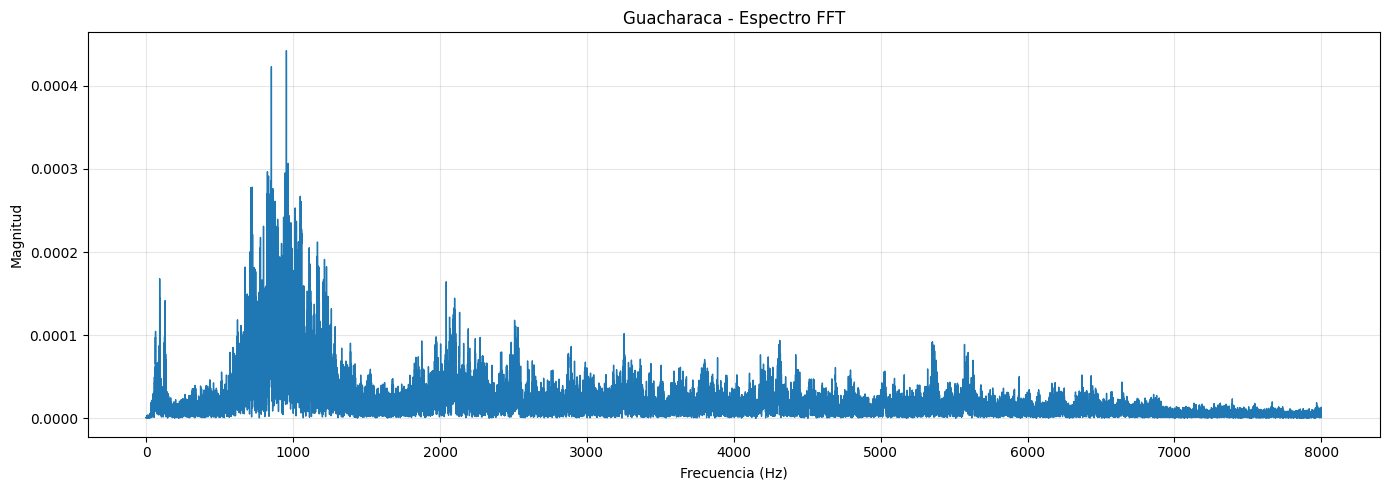

In [14]:
if guacharaca_path.exists():
    guacharaca_freqs, guacharaca_mags = compute_fft(guacharaca_audio, guacharaca_sr)
    plot_fft_spectrum(guacharaca_freqs, guacharaca_mags, "Guacharaca - Espectro FFT", max_freq=8000)

In [15]:
if guacharaca_path.exists():
    guacharaca_dominant = get_dominant_frequencies(guacharaca_freqs, guacharaca_mags, top_n=15)
    print("Frecuencias dominantes de la Guacharaca:")
    print("="*50)
    for i, (freq, mag) in enumerate(guacharaca_dominant, 1):
        print(f"{i:2d}. {freq:7.1f} Hz  (magnitud: {mag:.6f})")

Frecuencias dominantes de la Guacharaca:
 1.   954.0 Hz  (magnitud: 0.000442)
 2.   851.8 Hz  (magnitud: 0.000423)
 3.   954.2 Hz  (magnitud: 0.000422)
 4.   954.4 Hz  (magnitud: 0.000411)
 5.   851.9 Hz  (magnitud: 0.000397)
 6.   953.8 Hz  (magnitud: 0.000343)
 7.   851.6 Hz  (magnitud: 0.000342)
 8.   852.1 Hz  (magnitud: 0.000339)
 9.   966.1 Hz  (magnitud: 0.000306)
10.   953.3 Hz  (magnitud: 0.000304)
11.   824.8 Hz  (magnitud: 0.000297)
12.   944.4 Hz  (magnitud: 0.000295)
13.   832.4 Hz  (magnitud: 0.000291)
14.   949.2 Hz  (magnitud: 0.000288)
15.   953.7 Hz  (magnitud: 0.000286)


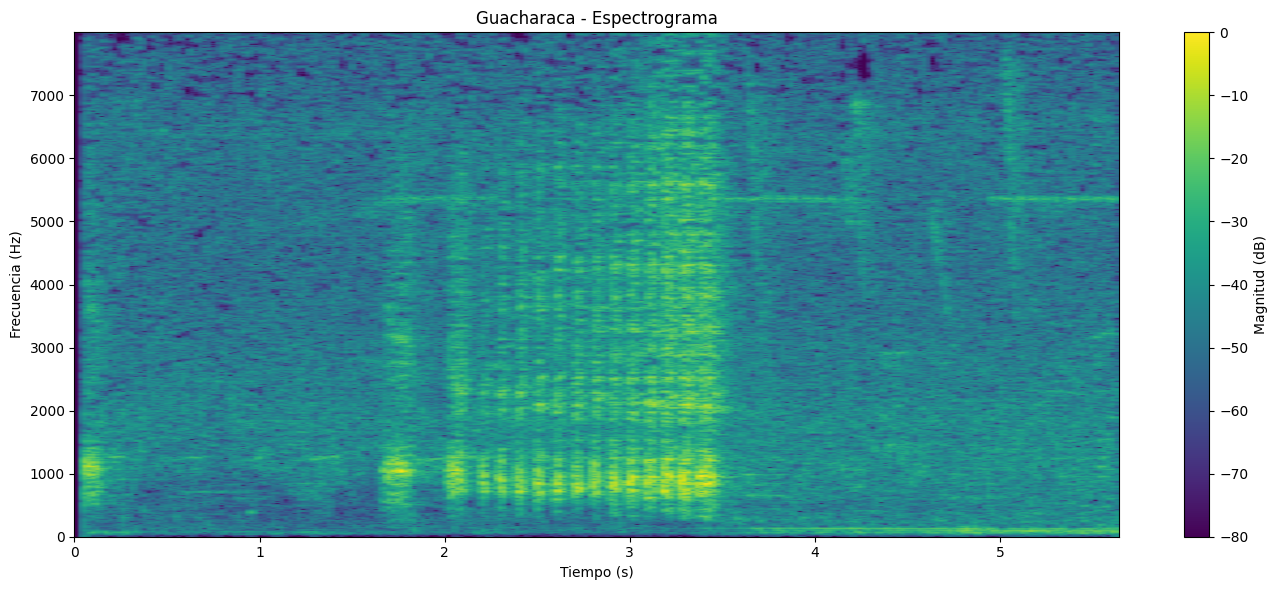

In [16]:
if guacharaca_path.exists():
    times_g, freqs_g, spec_g = compute_spectrogram(guacharaca_audio, guacharaca_sr)
    plot_spectrogram(times_g, freqs_g, spec_g, "Guacharaca - Espectrograma", max_freq=8000)

## Comparación de Espectros

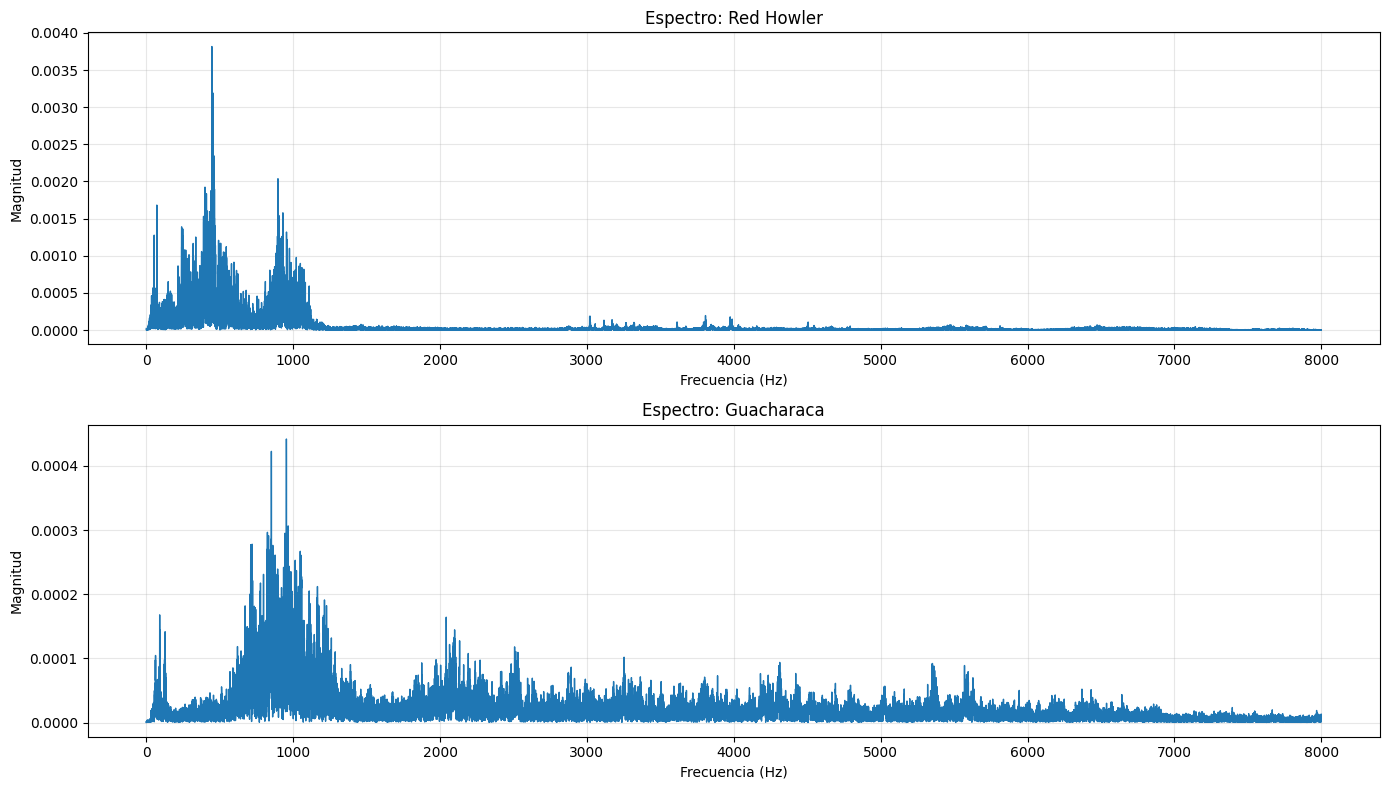

In [17]:
audio_comparison = {}

if howler_path.exists():
    audio_comparison["Red Howler"] = (howler_audio, howler_sr)

if guacharaca_path.exists():
    audio_comparison["Guacharaca"] = (guacharaca_audio, guacharaca_sr)

if audio_comparison:
    plot_comparison(audio_comparison, max_freq=8000)

## Sistema de Identificación Automática

In [18]:
identifier = BirdIdentifier(sample_rate=22050)

if howler_path.exists():
    identifier.add_reference("Red Howler (Alouatta seniculus)", 
                           str(howler_path), 
                           duration=10)

if guacharaca_path.exists():
    identifier.add_reference("Guacharaca", 
                           str(guacharaca_path), 
                           duration=10)

identifier.print_database()

Agregado: Red Howler (Alouatta seniculus)
  Frecuencias dominantes: [445 445 445 445 446] ... Hz
Agregado: Guacharaca
  Frecuencias dominantes: [720 824 832 847 851] ... Hz

BASE DE DATOS DE AVES

Red Howler (Alouatta seniculus):
  Frecuencias dominantes (Hz): [445 445 445 445 446 446 446 446 446 446]

Guacharaca:
  Frecuencias dominantes (Hz): [720 824 832 847 851 851 851 852 944 949]


## Identificar la Guacharaca de San Gil

In [19]:
mystery_bird_path = DATA_DIR / "guacharaca.mp3"

if mystery_bird_path.exists() and len(identifier.database) > 0:
    print("Identificando ave desconocida...")
    print(f"Archivo: {mystery_bird_path.name}")
    print()
    
    results = identifier.identify(str(mystery_bird_path), duration=10, top_n=3)
    
    print("="*70)
    print("RESULTADOS DE IDENTIFICACIÓN")
    print("="*70)
    
    for rank, (species, similarity) in enumerate(results, 1):
        confidence = similarity * 100
        match_quality = "ALTA" if similarity > 0.7 else "MEDIA" if similarity > 0.4 else "BAJA"
        print(f"\n{rank}. {species}")
        print(f"   Similitud: {similarity:.4f} ({confidence:.1f}%)")
        print(f"   Confianza: {match_quality}")
    
    print("\n" + "="*70)
    
    best_match, best_score = results[0]
    if best_score > 0.5:
        print(f"\n Ave identificada como: {best_match}")
        print(f"   Confianza: {best_score*100:.1f}%")
    else:
        print(f"\n No se encontró una coincidencia clara")
        print(f"   Mejor candidato: {best_match} ({best_score*100:.1f}%)")
else:
    print(" No se puede realizar la identificación (archivo no encontrado o base de datos vacía)")

Identificando ave desconocida...
Archivo: guacharaca.mp3

RESULTADOS DE IDENTIFICACIÓN

1. Guacharaca
   Similitud: 1.0000 (100.0%)
   Confianza: ALTA

2. Red Howler (Alouatta seniculus)
   Similitud: 0.0000 (0.0%)
   Confianza: BAJA


 Ave identificada como: Guacharaca
   Confianza: 100.0%


## Conclusiones

### ¿Cómo utilizar la FFT para identificar pájaros?

La **Transformada Rápida de Fourier (FFT)** nos permite identificar aves mediante el análisis de frecuencias de sus cantos:

#### 1. **Extracción de características**
- Cada especie de ave tiene un patrón único de frecuencias en su canto
- La FFT convierte la señal de audio del dominio temporal al dominio de frecuencias
- Identificamos las frecuencias dominantes que caracterizan cada especie

#### 2. **Creación de "huellas digitales" acústicas**
- Extraemos las N frecuencias más prominentes de cada especie
- Estas frecuencias forman una "firma" única para cada ave
- Similar a cómo Shazam identifica canciones

#### 3. **Proceso de identificación**
1. **Construcción de base de datos**: Analizar cantos conocidos de diferentes especies
2. **Análisis de audio desconocido**: Aplicar FFT al canto que queremos identificar
3. **Comparación**: Comparar las frecuencias dominantes con la base de datos
4. **Clasificación**: La especie con mayor similitud es la identificación

#### 4. **Ventajas del método FFT**
- **Rápido**: O(n log n) operaciones
- **Robusto**: Funciona con ruido de fondo moderado
- **Distintivo**: Cada especie tiene patrones únicos de frecuencia

#### 5. **Observaciones clave**
- Las aves tienen rangos de frecuencia característicos (típicamente 500-8000 Hz)
- El espectrograma muestra cómo varían las frecuencias en el tiempo
- Patrones repetitivos en el espectrograma indican llamados o cantos específicos

### Aplicaciones
- **Monitoreo de biodiversidad**: Identificación automática en grabaciones de campo
- **Conservación**: Seguimiento de especies en peligro
- **Educación**: Herramienta para aprender cantos de aves
- **Investigación**: Análisis de patrones de comunicación animal